# Multi-class Classification with CNNs: cifar-10

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import datasets

import datetime

notebook_start_time = datetime.datetime.now()
print(f"Notebook last run (end-to-end): {notebook_start_time}")

Notebook last run (end-to-end): 2025-04-27 22:28:03.306867


In [ ]:
import tensorflow_datasets as tfds
# Load the MNIST dataset from TensorFlow Datasets
train_ds, test_ds = tfds.load('mnist', split=['train', 'test'], as_supervised=True)

batch_size = 64
# Preprocess the dataset
train_ds = train_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

2025-04-27 22:32:16.741986: W tensorflow/core/kernels/data/cache_dataset_ops.cc:916] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


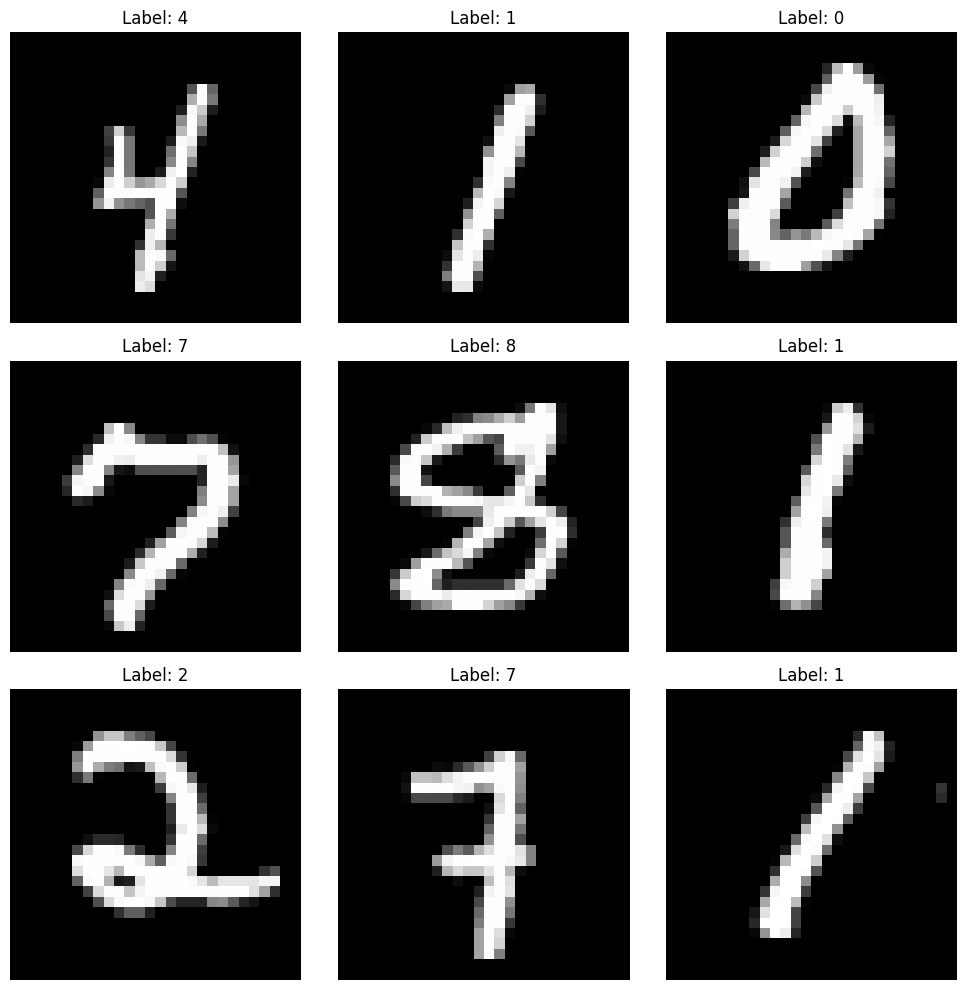

In [11]:
# Display a few images from the dataset
images, labels = next(iter(train_ds.take(1)))

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy(), cmap='gray')  # Added .numpy() to convert tensor to array
    plt.title(f"Label: {labels[i]}")
    plt.axis("off")
plt.tight_layout()
plt.show()

In [ ]:
y_true = np.concatenate([y for x, y in test_ds], axis=0)

def plot_confusion_matrix(y_true, test_ds, model, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    y_pred = np.argmax(model.predict(test_ds), axis=1)
    cm = tf.math.confusion_matrix(y_true, y_pred, num_classes=len(classes))
    cm = cm.numpy()
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    threshold = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], '.2f'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > threshold else "black")

    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

def get_class_training_weights(train_ds, normalize = True):
    labels, counts = np.unique(np.concatenate([y for x, y in train_ds], axis=0), return_counts=True)
    total = sum(counts)

    weights = [total/(2*count) for count in counts]
    max_weight = np.max(weights)

    if normalize:
        return {l : weights[i]/max_weight for i, l in enumerate(labels)}

    return {l : weights[i] for i, l in enumerate(labels)}

class_weight = get_class_training_weights(train_ds=train_ds)
for class_id, weight in class_weight.items():
    print(f"Class {int(class_id)}: {weight:.2f}")

Class 0: 0.92
Class 1: 0.80
Class 2: 0.91
Class 3: 0.88
Class 4: 0.93
Class 5: 1.00
Class 6: 0.92
Class 7: 0.87
Class 8: 0.93
Class 9: 0.91


In [ ]:
# those classes are close to balanced, so let's try not using class weights at least at first
model_count = 1
epochs = 20

In [29]:
from dataclasses import dataclass

class ModelBuilder:

    _input_shape = (28, 28, 1)
    _optimizer: tf.keras.Optimizer = None
    _layers_augmentation: list[tf.keras.Layer] = []
    _learning_rate: float = 1e-4
    _loss: tf.keras.Loss = None
    _metrics: list[tf.keras.Metric] = None
    _classes = 10

    def build(self, core_layers: list[tf.keras.Layer], name = "") -> tf.keras.models.Sequential:
        if self._optimizer is None:
            self._optimizer = tf.keras.optimizers.AdamW(learning_rate=self._learning_rate)

        if self._loss is None:
            if self._classes == 2:
                self._loss = tf.keras.losses.BinaryCrossentropy()
            else:
                self._loss = tf.keras.losses.SparseCategoricalCrossentropy()

        if self._metrics is None:
            self._metrics = [
                tf.keras.metrics.SparseCategoricalAccuracy(name='sparse_accuracy'),
            ]

        model = tf.keras.models.Sequential(name=name)

        model.add(tf.keras.layers.InputLayer(self._input_shape, name="input"))

        for layer in self._layers_augmentation:
            model.add(layer)

        model.add(tf.keras.layers.Rescaling(1./255, name="rescale"))
        for layer in core_layers:
            model.add(layer)
        if self._classes == 2:
            output = tf.keras.layers.Dense(1, activation="sigmoid", name="output")
        else:
            output = tf.keras.layers.Dense(self._classes, activation="softmax", name="output")
        model.add(output)
        model.compile(
            optimizer=self._optimizer,
            loss=self._loss,
            metrics=self._metrics
        )
        return model

    def loss(self, loss):
        """Loss function"""
        self._loss = loss
        return self

    def metrics(self, metrics):
        self._metrics = metrics
        return self

    def optimizer(self, optimizer):
        self._optimizer = optimizer
        return self

    def learning_rate(self, learning_rate):
        if self._optimizer is not None:
            raise Exception("Learning rate was specified after optimizer. Specify only the optimizer or only the learning rate")
        self._learning_rate = learning_rate
        return self

    def augmentation(self, layers: list[tf.keras.Layer] = None):
        if layers is None or not layers:
            layers = [
                tf.keras.layers.RandomFlip("horizontal", name="0.1rflip"),
                tf.keras.layers.RandomRotation(0.2, name="0.2rrot"),
                tf.keras.layers.RandomBrightness(0.2, name="0.3rbright"),
                tf.keras.layers.RandomContrast(0.2, name="0.4rcont"),
            ]
        self._layers_augmentation = layers
        return self

## Training

In [ ]:
# first attempt with just a dense neural net
model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255, name="rescale"),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(2048, activation='relu'),
    tf.keras.layers.Dense(2048, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])
history = model.fit(
    train_ds,
    batch_size=batch_size,
    epochs=10,
    validation_data=test_ds,
)

Epoch 1/10


938/938 ━━━━━━━━━━━━━━━━━━━━ 63s 66ms/step - loss: 0.4678 - sparse_categorical_accuracy: 0.8719 - val_loss: 0.1212 - val_sparse_categorical_accuracy: 0.9646
Epoch 2/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 62s 66ms/step - loss: 0.1069 - sparse_categorical_accuracy: 0.9694 - val_loss: 0.0913 - val_sparse_categorical_accuracy: 0.9727
Epoch 3/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 62s 66ms/step - loss: 0.0642 - sparse_categorical_accuracy: 0.9822 - val_loss: 0.0763 - val_sparse_categorical_accuracy: 0.9763
Epoch 4/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 63s 67ms/step - loss: 0.0412 - sparse_categorical_accuracy: 0.9891 - val_loss: 0.0700 - val_sparse_categorical_accuracy: 0.9776
Epoch 5/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 63s 67ms/step - loss: 0.0257 - sparse_categorical_accuracy: 0.9934 - val_loss: 0.0671 - val_sparse_categorical_accuracy: 0.9795
Epoch 6/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 62s 66ms/step - loss: 0.0152 - sparse_categorical_accuracy: 0.9968 - val_loss: 0.0710 - val_sparse_categorical_accuracy: 0.9794
Epo

157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step


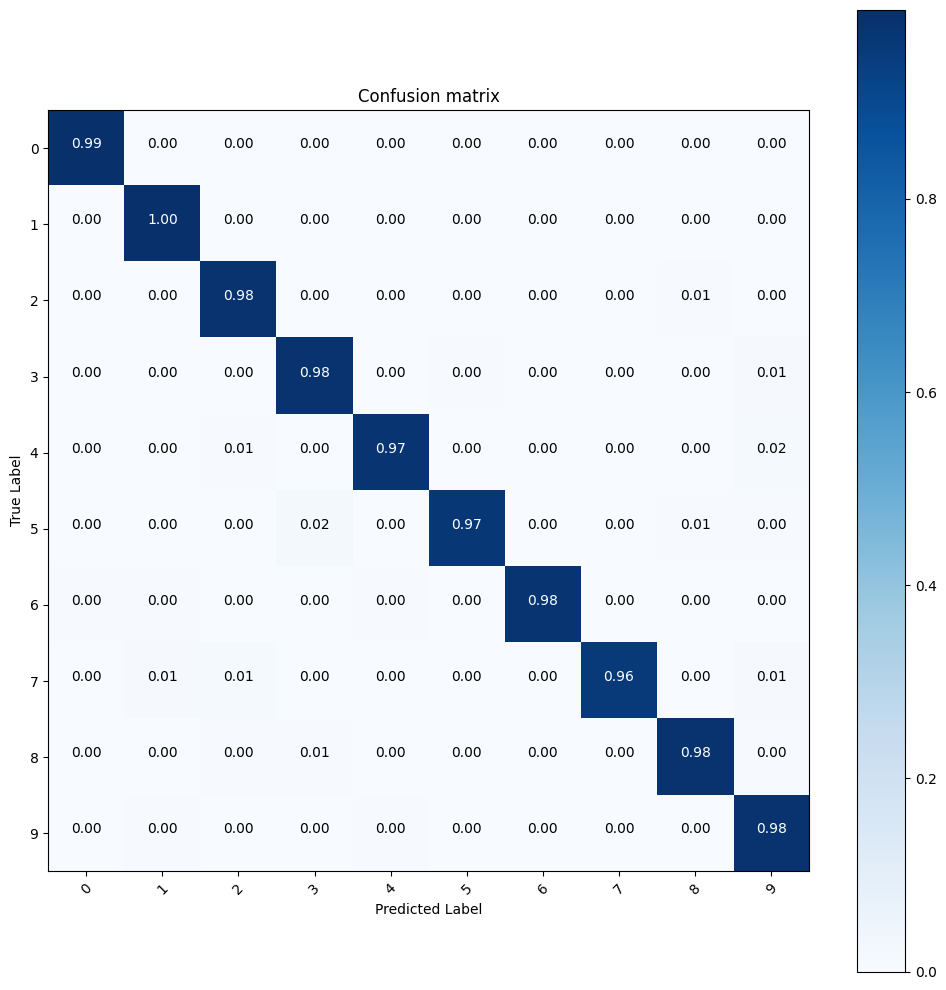

In [ ]:
plot_confusion_matrix(y_true, test_ds, model, classes=np.arange(10))

In [36]:
model_count = 1

In [37]:
core_layers = [
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2,2)),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2,2)),

    tf.keras.layers.Flatten(name="flatten"),
    tf.keras.layers.Dense(64, activation='relu'),
]

model = ModelBuilder().build(core_layers, name=f"Model_{model_count}")

history = model.fit(
    train_ds,
    epochs=10,
    validation_data=test_ds,
)

Epoch 1/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 36s 37ms/step - loss: 1.0062 - sparse_accuracy: 0.7252 - val_loss: 0.1963 - val_sparse_accuracy: 0.9431
Epoch 2/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 31s 33ms/step - loss: 0.1771 - sparse_accuracy: 0.9482 - val_loss: 0.1171 - val_sparse_accuracy: 0.9642
Epoch 3/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 42s 45ms/step - loss: 0.1130 - sparse_accuracy: 0.9677 - val_loss: 0.0869 - val_sparse_accuracy: 0.9726
Epoch 4/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 37s 40ms/step - loss: 0.0848 - sparse_accuracy: 0.9763 - val_loss: 0.0711 - val_sparse_accuracy: 0.9767
Epoch 5/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 32s 34ms/step - loss: 0.0699 - sparse_accuracy: 0.9807 - val_loss: 0.0621 - val_sparse_accuracy: 0.9798
Epoch 6/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 28s 30ms/step - loss: 0.0605 - sparse_accuracy: 0.9832 - val_loss: 0.0557 - val_sparse_accuracy: 0.9813
Epoch 7/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 32s 34ms/step - loss: 0.0540 - sparse_accuracy: 0.9845 - val_loss: 0.0513 - val_sparse_accuracy:

157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step


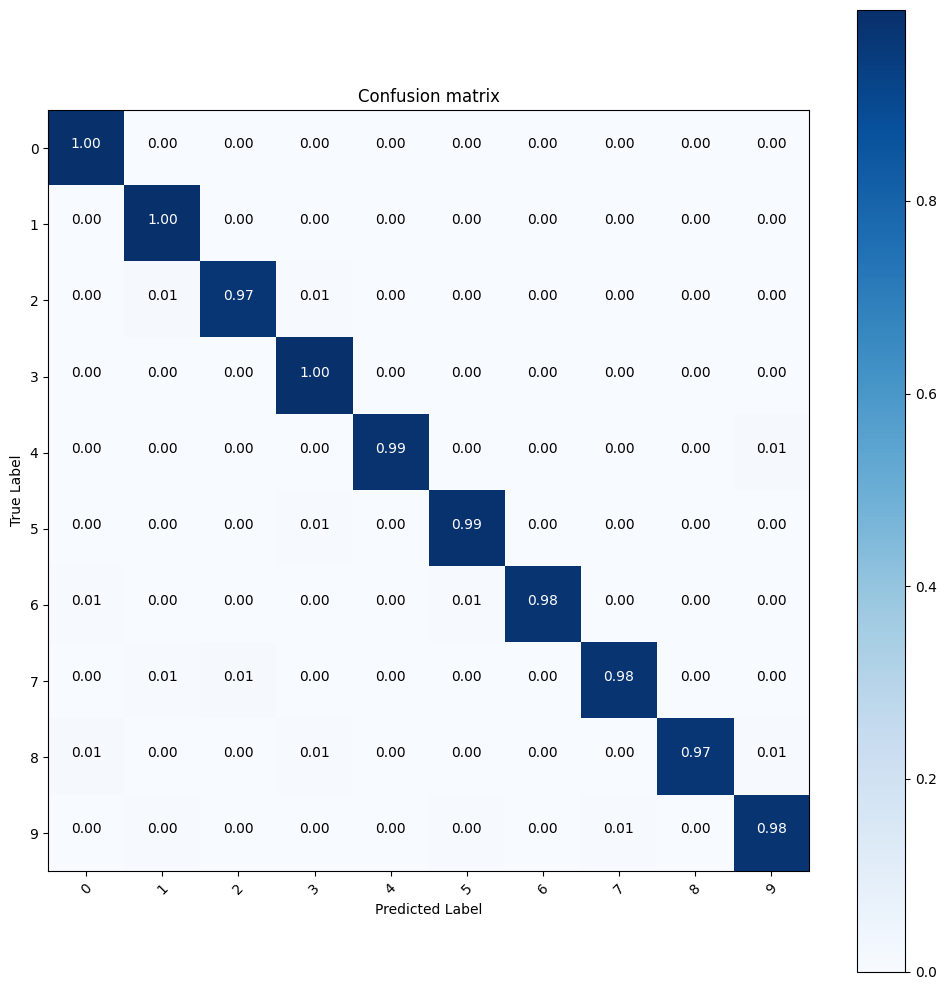

In [38]:
plot_confusion_matrix(y_true, test_ds, model, classes=np.arange(10))

In [39]:
model_count += 1
# this one is almost sure to overfit, but let's see how it does
core_layers = [
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2,2)),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2,2)),

    tf.keras.layers.Flatten(name="flatten"),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
]

model = ModelBuilder().build(core_layers, name=f"Model_{model_count}")

history = model.fit(
    train_ds,
    epochs=10,
    validation_data=test_ds,
)

Epoch 1/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 98s 101ms/step - loss: 0.7897 - sparse_accuracy: 0.7537 - val_loss: 0.1151 - val_sparse_accuracy: 0.9663
Epoch 2/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 84s 89ms/step - loss: 0.1026 - sparse_accuracy: 0.9702 - val_loss: 0.0728 - val_sparse_accuracy: 0.9764
Epoch 3/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 92s 98ms/step - loss: 0.0668 - sparse_accuracy: 0.9799 - val_loss: 0.0541 - val_sparse_accuracy: 0.9814
Epoch 4/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 99s 105ms/step - loss: 0.0504 - sparse_accuracy: 0.9845 - val_loss: 0.0474 - val_sparse_accuracy: 0.9843
Epoch 5/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 85s 91ms/step - loss: 0.0403 - sparse_accuracy: 0.9878 - val_loss: 0.0448 - val_sparse_accuracy: 0.9842
Epoch 6/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 89s 95ms/step - loss: 0.0331 - sparse_accuracy: 0.9895 - val_loss: 0.0414 - val_sparse_accuracy: 0.9855
Epoch 7/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 86s 92ms/step - loss: 0.0274 - sparse_accuracy: 0.9916 - val_loss: 0.0419 - val_sparse_accurac

157/157 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step


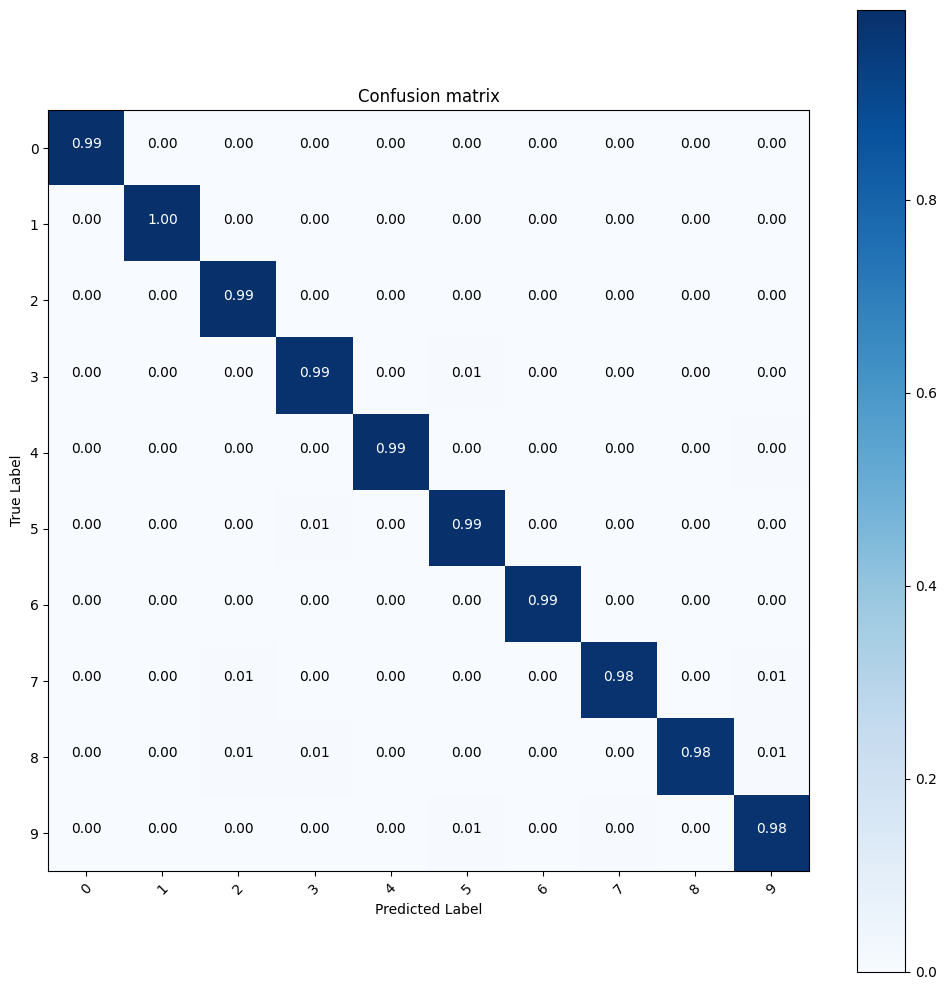

In [40]:
plot_confusion_matrix(y_true, test_ds, model, classes=np.arange(10))

Epoch 1/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 1.8704 - sparse_accuracy: 0.3427 - val_loss: 0.8309 - val_sparse_accuracy: 0.8147
Epoch 2/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.7349 - sparse_accuracy: 0.8225 - val_loss: 0.5077 - val_sparse_accuracy: 0.8699
Epoch 3/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.4880 - sparse_accuracy: 0.8690 - val_loss: 0.4092 - val_sparse_accuracy: 0.8901
Epoch 4/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.4043 - sparse_accuracy: 0.8883 - val_loss: 0.3637 - val_sparse_accuracy: 0.9005
Epoch 5/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.3623 - sparse_accuracy: 0.8974 - val_loss: 0.3374 - val_sparse_accuracy: 0.9069
Epoch 6/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.3357 - sparse_accuracy: 0.9047 - val_loss: 0.3194 - val_sparse_accuracy: 0.9118
Epoch 7/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.3167 - sparse_accuracy: 0.9097 - val_loss: 0.3058 - val_sparse_accuracy: 0.9154
Epoch 

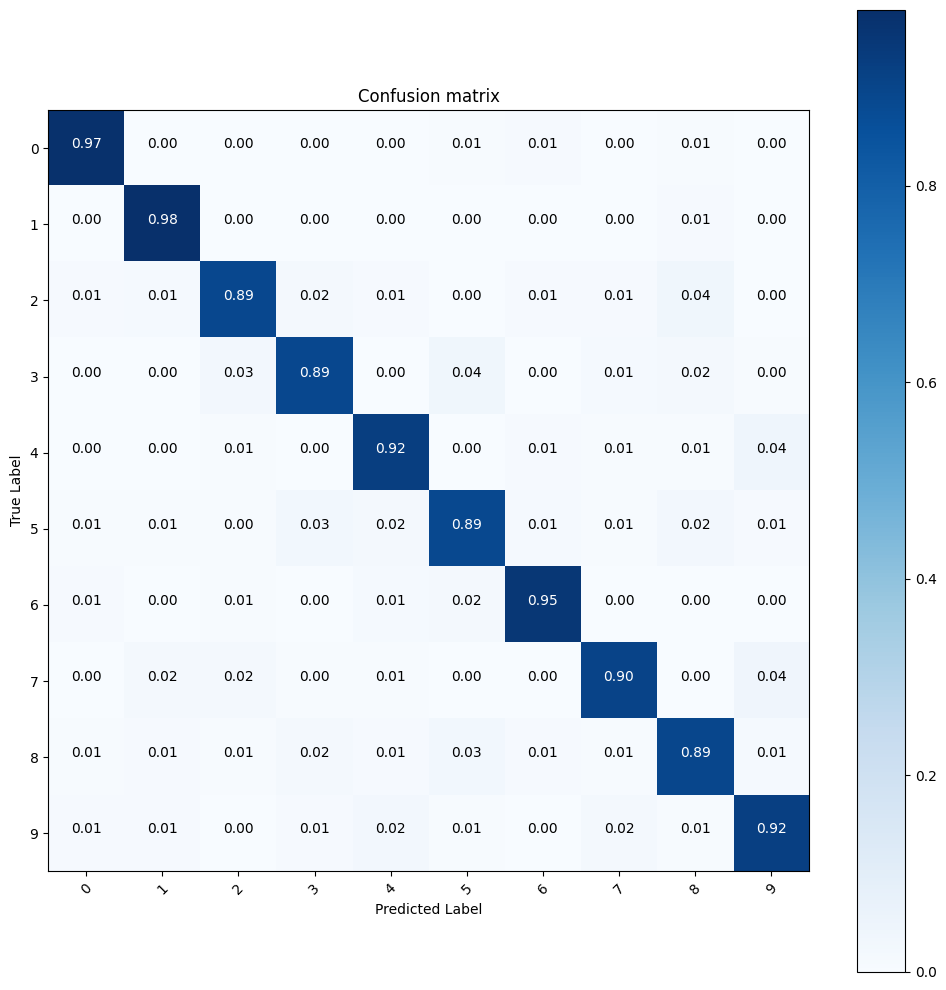

In [41]:
# so it looks like everything is fitting extremely well, so let's fit a really tiny model for fun
model_count += 1
core_layers = [
    tf.keras.layers.Flatten(name="flatten"),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
]

model = ModelBuilder().build(core_layers, name=f"Model_{model_count}")
history = model.fit(
    train_ds,
    epochs=10,
    validation_data=test_ds,
)
plot_confusion_matrix(y_true, test_ds, model, classes=np.arange(10))

In [42]:
notebook_end_time = datetime.datetime.now()
print(f"Notebook last run (end-to-end): {notebook_end_time} (duration: {notebook_end_time - notebook_start_time})")

Notebook last run (end-to-end): 2025-04-28 00:11:25.248584 (duration: 1:43:21.941717)
